# Introducción

El presente código es una ayuda para automatizar los cálculos de todos los ensayos que incluyan un proceso de consolidación para su ejecución (consolidación unidimensional, corte directo, triaxial).

Elaborado por: Juan A.

# Antes de iniciar

## Librerias a utilizar

In [1]:
import os
import scipy.optimize as opt
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
# from sklearn.metrics import r2_score

In [60]:
import json

file_name = "data_S4M4.json"
name = os.path.splitext(file_name)[0].split("_")[1]

with open(file_name) as data:
  data_contents = json.load(data)

In [63]:
initial_data = data_contents["datos_iniciales"]

h = np.average(initial_data[0]["valor"]) # (mm)
d = np.average(initial_data[1]["valor"]) # (mm)
Gs = initial_data[2]["valor"] # (-)
w_o = initial_data[3]["valor"] # (-)
m_bp = initial_data[4]["valor"]/1e3 # (kg)
m_i = initial_data[5]["valor"]/1e3 # (kg)

A = np.pi/4 * d**2 # (mm2)
V = A*h / (1e9) # (m3)

y_w = 9.81 # (kPa)

y_t = m_i/V * 9.81/1e3 # (kPa)
e_o = Gs*y_w/y_t * (1 + w_o) - 1

annotations = data_contents["lecturas"]

In [64]:
stages = annotations[-1]["etapa"] + 1

compressibility_data = pd.DataFrame(index = range(stages),
                                    columns = ["Masa (kg)", "Esf. efec. (kPa)",
                                               "dH (mm)", "Def. vertical acum. (-)",
                                               "e (-)", "Cv (cm2/s)"])



for i in range(stages):
    # print(annotations[i]["deformacion"])
    h_i = annotations[i]["deformacion"]["inicial"]
    h_f = annotations[i]["deformacion"]["final"]
    d_h = h_i - h_f

    load = annotations[i]["carga"]["valor"] * 10 # (kg)

    e_i = e_o - d_h/h * (1 + e_o)

    compressibility_data.iloc[i, [0, 2, 4]] = [load + m_bp, d_h, e_i]

compressibility_data.iloc[:, 1] = compressibility_data.iloc[:, 0]/A * 9.81*1e3
compressibility_data.iloc[:, 3] = compressibility_data.iloc[:, 2].cumsum() / h
compressibility_data.iloc[:, 4] = e_o - compressibility_data.iloc[:, 3] * (1 + e_o)

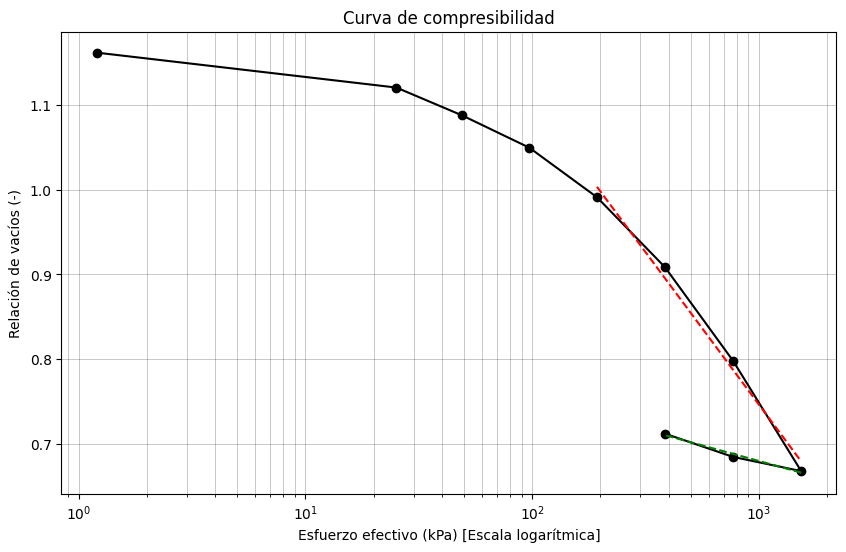

In [66]:
log_linear = lambda x, a, b: a * np.log10(x) + b

X1 = compressibility_data.iloc[4:8, 1].astype(float)
Y1 = compressibility_data.iloc[4:8, 4].astype(float)
X2 = compressibility_data.iloc[7:11, 1].astype(float)
Y2 = compressibility_data.iloc[7:11, 4].astype(float)

popt_Cr, pcov_Cr = opt.curve_fit(log_linear, X1, Y1)
popt_Cc, pcov_Cc = opt.curve_fit(log_linear, X2, Y2) 

s1 = lambda x: log_linear(x.astype(float), *popt_Cr)
s2 = lambda x: log_linear(x.astype(float), *popt_Cc)

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(compressibility_data.iloc[:, 1], compressibility_data.iloc[: , 4], "ko-")
ax.plot(X1, s1(X1), "r--")
ax.plot(X2, s2(X2), "g--")
ax.set_title("Curva de compresibilidad")
ax.set_xlabel("Esfuerzo efectivo (kPa) [Escala logarítmica]")
ax.set_ylabel("Relación de vacíos (-)")

ax.grid(True, color = 'k', which = "both", alpha = 0.3, linestyle = '-', linewidth = 0.5)
ax.set_xscale("log")

plt.savefig(name + "_compresibilidad.png", dpi = 300)

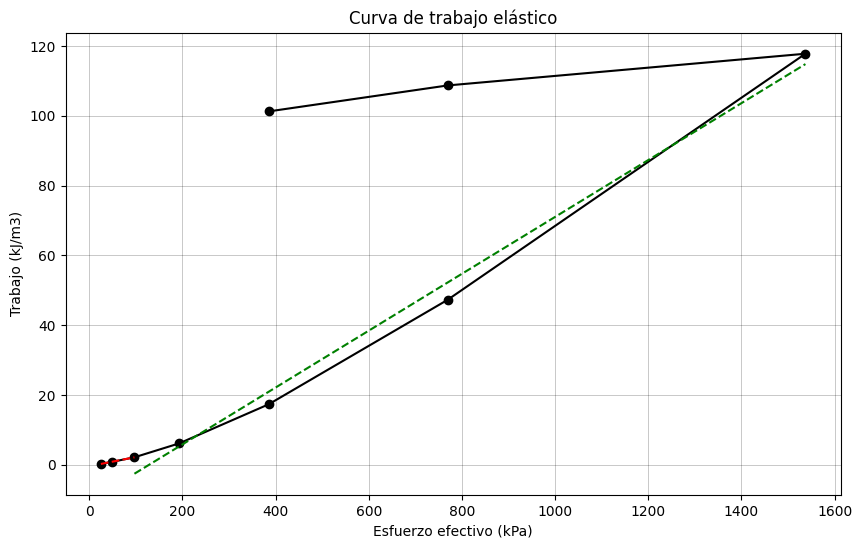

In [68]:
work_data = pd.DataFrame(index = range(compressibility_data.shape[0]),
                         columns = ["Esf. efec. (kPa)", "Def. vertical (-)",
                                    "dW (kJ/m3)", "W (kJ/m3)"])
work_data.iloc[:, 0] = compressibility_data.iloc[:, 1]
work_data.iloc[:, 1] = compressibility_data.iloc[:, 3]
work_data.iloc[:, 2] = work_data.iloc[:, 0].rolling(2).sum()/2 * work_data.iloc[:, 1].diff()
work_data.iloc[:, 3] = work_data.iloc[:, 2].cumsum()

linear = lambda x, m, b: m*x + b

X1 = work_data.iloc[1:4, 0]
Y1 = work_data.iloc[1:4, 3]
X2 = work_data.iloc[3:8, 0]
Y2 = work_data.iloc[3:8, 3]

popt1, pcov1 = opt.curve_fit(linear, X1, Y1)
popt2, pcov2 = opt.curve_fit(linear, X2, Y2)

f1 = lambda x: linear(x, *popt1)
f2 = lambda x: linear(x, *popt2)
h = lambda x: f1(x) - f2(x)

pre_stress = opt.newton(h, 1)

fig3, ax3 = plt.subplots(figsize = (10, 6))

ax3.plot(work_data.iloc[:, 0], work_data.iloc[:, 3], "ko-")
# ax3.plot(work_data.iloc[:, 0], f1(work_data.iloc[:, 0]), "r--")
ax3.plot(X1, f1(X1), "r--")
# ax3.plot(work_data.iloc[:, 0], f2(work_data.iloc[:, 0]), "g--")
ax3.plot(X2, f2(X2), "g--")
ax3.set_title("Curva de trabajo elástico")
ax3.set_xlabel("Esfuerzo efectivo (kPa)")
ax3.set_ylabel("Trabajo (kJ/m3)")

ax3.grid(True, color = 'k', which = "both", alpha = 0.3, linestyle = '-', linewidth = 0.5)
# ax3.set_xlim([0, 200])
# ax3.set_ylim([0, 25])
# plt.close()

plt.savefig(name + "_trabajo.png", dpi = 300)

In [70]:
print(f"El esfuerzo efectivo de consolidación fue de {pre_stress} kPa")
print(f"El Cc es {popt_Cc[0]}")
print(f"El Cr es {popt_Cr[0]}")

El esfuerzo efectivo de consolidación fue de 182.21181475591825 kPa
El Cc es -0.07355033706784503
El Cr es -0.359420270465417


In [ ]:
#!pip install statsmodels
#!pip install scikit-learn

# Consolidación Unidimensional

En desarrollo

## **Bancos** de Pinzuar

### *Datos de entrada*

---

Dentro de los parámetros de entrada se encuentran contempladas variables como:

* Altura de drenaje / espécimen ( $H$ )
* Gravedad específica ( $G_s$ )
* Contenido de agua inicial ( $w_o$ )
* Contenido de agua final ( $w_f$ )
* Peso unitario del agua ( $\gamma_w$ )
* Peso unitario total inicial ( $\gamma_{t,o}$ )
* Peso unitario total final ( $\gamma_{t,f}$ )

---


In [ ]:
H = 25 # (mm)
D = 50.6 # (mm)
Gs = 2.67 # (-)
wo = 0.475 # (-)
# wf =
yw = 9.81 # (kPa)
yto = 15.30 # (kPa)
# ytf =
m = 0.25163 # (kg)
g = 9.81 # (m/s2)

A = np.pi/4 * D**2
eo = Gs*yw/yto * (1+wo) - 1

In [ ]:
def readings_no_saved():
    hi = float(input("¿Cuál fue la lectura inicial? "))
    hf = float(input("¿Cuál fue la lectura final? "))
    dh = hi - hf

    return dh

def print_stage(stage):
    print(f"\nEtapa {stage+1}\n")

# n = int(input("¿Cuántas etapas se realizaron entre precarga, carga y descarga? "))
# n_pre = int(input("¿Cuántas de precarga? "))
# n_load = int(input("¿Cuántas de carga? "))
# n_dis = n - n_pre - n_load

n, n_pre, n_load, n_dis = 13, 1, 9, 3
stage = 0

compressibility_data = pd.DataFrame(index = range(n),
                                    columns = ["Masa (kg)", "Esf. efec. (kPa)",
                                               "dH (mm)", "Def. vertical acum. (-)",
                                               "e (-)", "Cv (cm2/s)"])

for i in range(n_pre):
    print_stage(stage)
    dh = readings_no_saved()

    if stage == 0:
        compressibility_data.iloc[stage, [0, 2, 4]] = [m, dh, eo]
    else:
        compressibility_data.iloc[stage, [0, 2]] = [m, dh]

    stage += 1

stage += n_load

for j in range(n_dis):
    print_stage(stage)
    load = float(input(f"¿Cuál es la carga remanente? (kg) "))
    dh = readings_no_saved()
    compressibility_data.iloc[stage, [0, 2]] = [load*10 + m, dh]

    stage += 1

print("\n")
display(compressibility_data)

# 3.733


Etapa 1

¿Cuál fue la lectura inicial? 0.001
¿Cuál fue la lectura final? 0.043

Etapa 11

¿Cuál es la carga remanente? (kg) 16
¿Cuál fue la lectura inicial? -5.357
¿Cuál fue la lectura final? -5.227

Etapa 12

¿Cuál es la carga remanente? (kg) 4
¿Cuál fue la lectura inicial? -5.227
¿Cuál fue la lectura final? -4.823

Etapa 13

¿Cuál es la carga remanente? (kg) 1
¿Cuál fue la lectura inicial? -4.823
¿Cuál fue la lectura final? -3.733




,Masa (kg),Esf. efec. (kPa),dH (mm),Def. vertical acum. (-),e (-),Cv (cm2/s)
0,0.25163,NaN,-0.042,NaN,1.525113,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


### *Análisis de las curvas de consolidación*

In [ ]:
Ri = lambda R1, t1, R2, t2: (R1 - R2 * np.sqrt(t1/t2))/(1 - np.sqrt(t1/t2))
Rf = lambda R1, t1, R2, t2, R3, t3, R0:  R0 - (R0 - R3)/np.power(1 - np.power(((R0 - R3)*(np.sqrt(t2) - np.sqrt(t1)))/((R1 - R2)*np.sqrt(t3)), 5.6), 0.179)
Cv = lambda R1, t1, R2, t2, R0, R100: np.pi/4 * np.power((R0 - R2)/(R0 - R100) * H/(np.sqrt(t2) - np.sqrt(t1)), 2)

for i, file_name in enumerate(files):

    file_path = dir + file_name

    data = pd.read_excel(file_path, 2).filter(items = ["Tiempo(s)", "Deformación(mm)"])
    data = data[data["Tiempo(s)"] < 35000]

    t1, R1 = data.iloc[10, :]
    t2, R2 = data.iloc[35, :]
    t3, R3 = data.iloc[110, :]

    R0 = Ri(R1, t1, R2, t2)
    R100 = Rf(R1, t1, R2, t2, R3, t3, R0)
    Cvi = Cv(R1, t1, R2, t2, R0, R100)*0.01

    compressibility_data.iloc[n_pre+i, 0] = float(Path(file_name).stem.split(" ")[0])*10 + m
    compressibility_data.iloc[n_pre+i, 2] = -(data.iloc[data.shape[0]-1, 1] - data.iloc[0, 1])
    compressibility_data.iloc[n_pre+i, 5] = Cvi

    fig1, ax1 = plt.subplots(figsize = (10, 6))

    ax1.plot(data.iloc[:, 0], data.iloc[:, 1], "k")
    ax1.plot(t1, R1, "ro", label = "R1")
    ax1.plot(t2, R2, "bo", label = "R2")
    ax1.plot(t3, R3, "go", label = "R3")

    name = " ".join(["Curva de consolidación", Path(file_name).stem])
    ax1.set_title(name)
    ax1.set_ylabel("Deformación (mm)")
    ax1.set_xlabel("Tiempo (s)")

    ax1.grid(True, color = 'k', which = "both", alpha = 0.3, linestyle = '-', linewidth = 0.5)
    ax1.legend()
    # plt.savefig(results_path + name + ".png")
    plt.close()

display(compressibility_data)

,Masa (kg),Esf. efec. (kPa),dH (mm),Def. vertical acum. (-),e (-),Cv (cm2/s)
0,0.25163,NaN,-0.042,NaN,1.525113,NaN
1,1.25163,NaN,0.019,NaN,NaN,0.007962
2,2.75163,NaN,0.05,NaN,NaN,0.01146
3,5.25163,NaN,0.104,NaN,NaN,0.009498
4,10.25163,NaN,0.498,NaN,NaN,0.023672
5,20.25163,NaN,0.66,NaN,NaN,0.008262
6,40.25163,NaN,0.975,NaN,NaN,0.004915
7,80.25163,NaN,1.053,NaN,NaN,0.003076
8,160.25163,NaN,1.078,NaN,NaN,0.003173
9,320.25163,NaN,0.88,NaN,NaN,0.003629


### *Análisis de la curva de compresibilidad*

,Masa (kg),Esf. efec. (kPa),dH (mm),Def. vertical acum. (-),e (-),Cv (cm2/s)
0,0.25163,1.227554,-0.042,-0.00168,1.529355,NaN
1,1.25163,6.105961,0.019,-0.00092,1.527436,0.007962
2,2.75163,13.423573,0.05,0.00108,1.522386,0.01146
3,5.25163,25.619592,0.104,0.00524,1.511882,0.009498
4,10.25163,50.011631,0.498,0.02516,1.461581,0.023672
5,20.25163,98.795708,0.66,0.05156,1.394918,0.008262
6,40.25163,196.363862,0.975,0.09056,1.296439,0.004915
7,80.25163,391.50017,1.053,0.13268,1.190081,0.003076
8,160.25163,781.772785,1.078,0.1758,1.081198,0.003173
9,320.25163,1562.318017,0.88,0.211,0.992314,0.003629


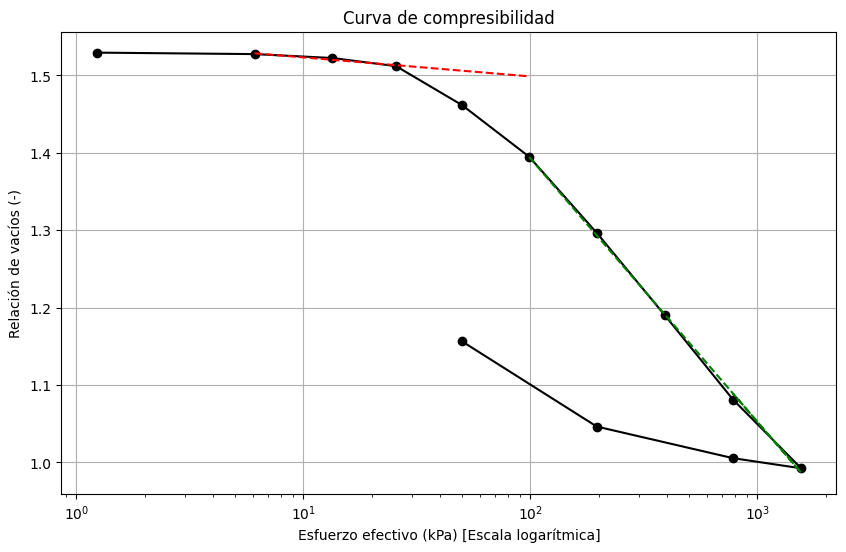

In [ ]:
compressibility_data.iloc[:, 1] = compressibility_data.iloc[:, 0]*g / A * 1e3
compressibility_data.iloc[:, 3] = compressibility_data.iloc[:, 2].cumsum() / H
compressibility_data.iloc[:, 4] = eo - compressibility_data.iloc[:, 3] * (1 + eo)

display(compressibility_data)
print("\n")

log_linear = lambda x, a, b: a * np.log10(x) + b

popt_Cr, pcov_Cr = opt.curve_fit(log_linear, compressibility_data.iloc[n_pre:n_pre+3, 1].astype(float), compressibility_data.iloc[n_pre:n_pre+3, 4])
popt_Cc, pcov_Cc = opt.curve_fit(log_linear, compressibility_data.iloc[n_pre+5:n_pre+9, 1].astype(float), compressibility_data.iloc[n_pre+5:n_pre+9, 4])

s1 = lambda x: log_linear(x.astype(float), *popt_Cr)
s2 = lambda x: log_linear(x.astype(float), *popt_Cc)

x1 = compressibility_data.iloc[n_pre:n_pre+5, 1]
x2 = compressibility_data.iloc[n_pre+4:n_pre+10, 1]

fig2, ax2 = plt.subplots(figsize = (10, 6))

ax2.plot(compressibility_data.iloc[:, 1], compressibility_data.iloc[: , 4], "ko-")
ax2.plot(x1, s1(x1), "r--")
ax2.plot(x2, s2(x2), "g--")
ax2.set_title("Curva de compresibilidad")
ax2.set_xlabel("Esfuerzo efectivo (kPa) [Escala logarítmica]")
ax2.set_ylabel("Relación de vacíos (-)")

ax2.grid(True, color = 'k', which = "both", alpha = 0.3, linestyle = '-', linewidth = 0.5)
ax2.set_xscale("log")
# plt.show()
# plt.savefig(results_path + "Curva de compresibilidad.png")
# plt.close()

### *Esfuerzo de preconsolidación*

,Esf. efec. (kPa),Def. vertical (-),dW (kJ/m3),W (kJ/m3)
0,1.227554,-0.00168,NaN,NaN
1,6.105961,-0.00092,0.002787,0.002787
2,13.423573,0.00108,0.01953,0.022316
3,25.619592,0.00524,0.08121,0.103526
4,50.011631,0.02516,0.753287,0.856813
5,98.795708,0.05156,1.964257,2.82107
6,196.363862,0.09056,5.755612,8.576682
7,391.50017,0.13268,12.380416,20.957098
8,781.772785,0.1758,25.295765,46.252863
9,1562.318017,0.211,41.255998,87.508861


115.44240909174253


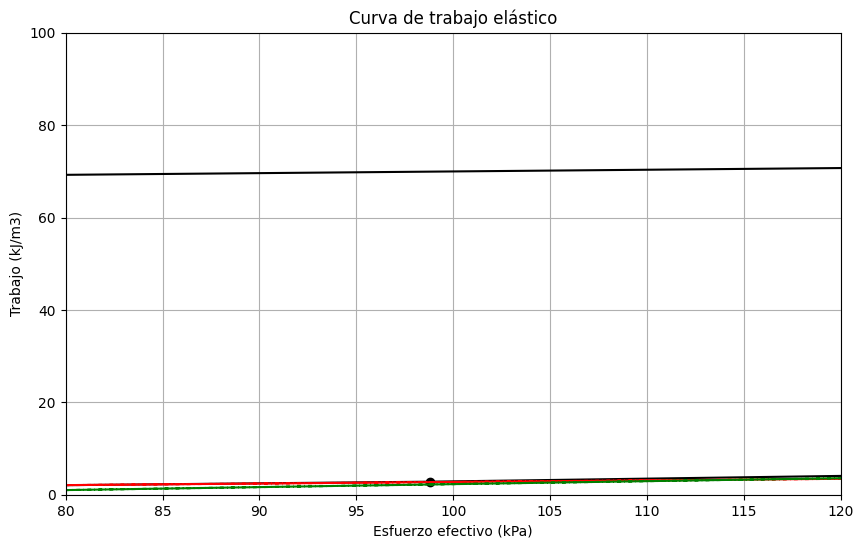

In [ ]:
work_data = pd.DataFrame(index = range(compressibility_data.shape[0]),
                         columns = ["Esf. efec. (kPa)", "Def. vertical (-)",
                                    "dW (kJ/m3)", "W (kJ/m3)"])
work_data.iloc[:, 0] = compressibility_data.iloc[:, 1]
work_data.iloc[:, 1] = compressibility_data.iloc[:, 3]
work_data.iloc[:, 2] = work_data.iloc[:, 0].rolling(2).sum()/2 * work_data.iloc[:, 1].diff()
work_data.iloc[:, 3] = work_data.iloc[:, 2].cumsum()

display(work_data)

linear = lambda x, m, b: m*x + b

popt1, pcov1 = opt.curve_fit(linear, work_data.iloc[n_pre+1:n_pre+5, 0], work_data.iloc[n_pre+1:n_pre+5, 3])
popt2, pcov2 = opt.curve_fit(linear, work_data.iloc[n_pre+5:n_pre+8, 0], work_data.iloc[n_pre+5:n_pre+8, 3])

f1 = lambda x: linear(x, *popt1)
f2 = lambda x: linear(x, *popt2)
h = lambda x: f1(x) - f2(x)

pre_stress = opt.newton(h, 1)

fig3, ax3 = plt.subplots(figsize = (10, 6))

ax3.plot(work_data.iloc[:, 0], work_data.iloc[:, 3], "ko-")
ax3.plot(work_data.iloc[:, 0], f1(work_data.iloc[:, 0]), "r--")
ax3.plot(work_data.iloc[:, 0], f2(work_data.iloc[:, 0]), "g--")
ax3.set_title("Curva de trabajo elástico")
ax3.set_xlabel("Esfuerzo efectivo (kPa)")
ax3.set_ylabel("Trabajo (kJ/m3)")

ax3.grid(True, color = 'k', which = "both", alpha = 0.3, linestyle = '-', linewidth = 0.5)
ax3.set_xlim([80, 120])
ax3.set_ylim([0, 100])
# plt.close()

In [ ]:
r2_1 = r2_score(work_data.iloc[2:6, 3], f1(work_data.iloc[2:6, 0]))
r2_2 = r2_score(work_data.iloc[6:9, 3], f2(work_data.iloc[6:9, 0]))

print(r2_1, r2_2)

0.9783098220316838 0.9999722873229613


### Resultados

In [ ]:
print(f"El Cv fue de {np.nanmedian(compressibility_data.iloc[:, 5])} cm2/s")
print(f"El esfuerzo efectivo de consolidación fue de {pre_stress} kPa")
print(f"El Cc es {popt_Cc[0]}")
print(f"El Cr es {popt_Cr[0]}")

# Corte Directo

En desarrollo

# Triaxial

En desarrollo

In [ ]:
data_file = "/SM1-10-M6A/0.1 Kg.xlsx"

data = pd.read_excel(root + data_file, 2)

h0 = data.iloc[0, 4]
d0 = data.iloc[0, 6]

data =  data.filter(items = ["Tiempo(s)", "Deformación(mm)"])

print(data)

data["Deformación(mm)"] = data["Deformación(mm)"] - data["Deformación(mm)"][0]

print("\n ---- \n")

print(data)

data["Tiempo(s)"] = np.sqrt(data["Tiempo(s)"]/60)
data["Deformación(mm)"] = - data["Deformación(mm)"]/h0 * 100

data.set_axis(["sqrt_Time (min)", "Axial Strain (%)"], axis = "columns", inplace = True)

fig, ax1 = plt.subplots(1, 1)

plt.plot(data["sqrt_Time (min)"], data["Axial Strain (%)"])

ax1.plot(data["sqrt_Time (min)"], data["Axial Strain (%)"])
ax1.set_ylim([0, 1.1*max(data["Axial Strain (%)"])])
ax1.invert_yaxis()
ax1.grid()